# ESDL Early Adopters Call Project: Multivariate Extreme Event Detection on ESDL Colombian data cube


## Libraries 

In [210]:
import xarray as xr
import numpy as np
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from esdl.cube_store import CubesStore
from numpy.fft import fft, ifft, fftfreq, rfft, irfft, rfftfreq

## Cube importation

In [211]:
cs = CubesStore()
colombia=cs['CUBE_V2.0.1_colombia_time_optimized_0.083deg']

## Toolbox
This is a set of functions we created in order to explore and process the cube data

In [221]:
#Custom functions
#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Generates a video of variable over time, the video it's saved in the main folder as a .mp4
#tmp must be a subcube with 1 variable 
def plot_animation(dArray,filename='video'):
    fig = plt.figure()
    ims = []

    for i in range(len(dArray['time'].values)):
        im = plt.imshow(dArray.isel(time=i), animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

    ani.save(filename+'.mp4')
    
    
#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series
def time2freqDataset(timeCube,samplingSpacing=8,variables=['evapotranspiration'],chunksize={'frequency':184,'lat':60,'lon':60}):
    """
    This function takes a xarray dataset cube this dimentions latitude, longitude and time and 
    returns a cube with dimentions latitude, longitude and frequency>=0 with the variables given. 
    The values of each variable are replaced with the values of the absolute values of the Fourier coefficients. 
    The time series are standardized and then the FFT is applied. The data is assumed to be real and 
    so Hermitian-symmetric under FFT.
    """
    #creates a Dataset with only the given variables
    freqCube=timeCube[variables].copy()
    #changes the time dimension to frequency
    freqCube=freqCube.rename({'time':'frequency'})
    #adds the correct values for the frequency
    freqCube.coords['frequency']=fftfreq(len(freqCube['frequency']),samplingSpacing)
    #runs for every variable given
    for var in variables:
        #loads the variable so that we can assign particular values to the DataArray
        freqCube[var].load()
        #runs for every latitude and longitude
        for lat in freqCube['lat']:
            for lon in freqCube['lon']:
                #selects the respective time series for the latitude,longitude
                timeSeries=freqCube[var].loc[{'lon':lon,'lat':lat,'method':'nearest'}].values
                #standardizes the time series
                normSeries=(timeSeries-np.mean(timeSeries))/np.std(timeSeries)
                #applies the FFT
                fourierSeries=fft(normSeries)
                #assigns the absolute values of the fourier coefficients
                freqCube[var].loc[{'lon':lon,'lat':lat,'method':'nearest'}]=np.abs(fourierSeries)
    #since the data is real the Dataset would have a reflection around frequency=0 so the frequencies<0 are not necessary,
    #also the chunking is applied
    return freqCube.where(freqCube['frequency']>=0).chunk(chunksize)

## Workflow

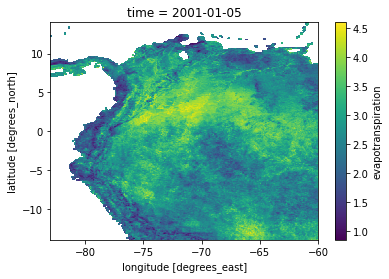

In [219]:
#first we make a simple plot of the cube we are going to work with
colombia.evapotranspiration[0,:,:].plot()

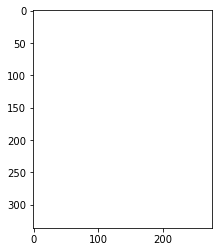

In [224]:
#now let's see it over time (this function generates the video)
plot_animation(colombia.evapotranspiration)

In [225]:
#this to visualize the video
HTML("""
    <div align="middle">
    <video width="50%" controls>
          <source src="video.mp4" type="video/mp4">
    </video></div>""")

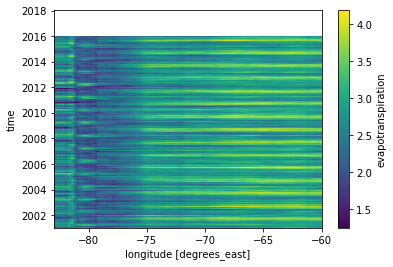

In [111]:
#We can see around the end of the video that there might be dates with no values so we have to select the 
#correct dates where we are going to work for example if we work with evapotranspiration
ET=colombia.evapotranspiration
nantime=ET.reduce(np.nanmean,dim='lat')
nantime.plot()

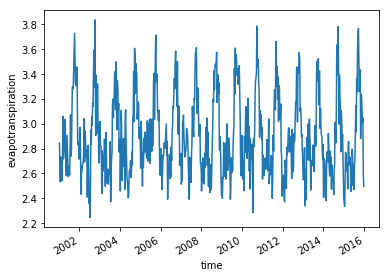

In [112]:
#it is clear that the values for the dates beginning with 2016 are missing, let's select the working dates
nantime=nantime.reduce(np.nanmedian,dim='lon')
allDates=nantime['time'].values
workingDates=allDates[np.logical_not(np.isnan(nantime.values))]
nantime.plot()

In [121]:
#we can select the first and last so we can make slices of time
sliceDates=slice(workingDates[0],workingDates[-1])
print((workingDates[0],workingDates[-1]))

(numpy.datetime64('2001-01-05T00:00:00.000000000'), numpy.datetime64('2015-12-31T00:00:00.000000000'))


In [123]:
#next we select a subcube with variables without a lot of nans in an area but only in the time slice
colombia=colombia.sel(time=sliceDates)
sectionCol, features=explore_nulls(colombia,threshold=10)

bihemispheric_reflectance_near_infrared null_percentage = 0.00
bihemispheric_reflectance_shortwave null_percentage = 0.00
burn_date null_percentage = 0.00
directional_hemispheric_reflectance_near_infrared null_percentage = 0.00
directional_hemispheric_reflectance_shortwave null_percentage = 0.00
directional_hemispheric_reflectance_visible null_percentage = 0.00
enhanced_vegetation_index_terra null_percentage = 0.00
evapotranspiration null_percentage = 0.00
fapar null_percentage = 6.99
gross_primary_productivity null_percentage = 0.00
lat_bnds null_percentage = 0.00
leaf_area_index null_percentage = 0.32
lon_bnds null_percentage = 0.00
normalized_difference_vegetation_index_terra null_percentage = 0.00
precipipation_chirps null_percentage = 0.00
surface_diffuse_downwelling_photosynthetic_radiative_flux null_percentage = 0.34
surface_downwelling_photosynthetic_radiative_flux null_percentage = 0.00
surface_downwelling_shortwave_flux null_percentage = 0.34
time_bnds null_percentage = 0.00


In [133]:
#let's work with 2 very good features in the small selected region
variables=['evapotranspiration','gross_primary_productivity']
sectionCol=sectionCol[variables]
sectionCol

<xarray.Dataset>
Dimensions:                     (lat: 120, lon: 120, time: 690)
Coordinates:
  * lon                         (lon) float64 -74.88 -74.79 ... -65.04 -64.96
  * time                        (time) datetime64[ns] 2001-01-05 ... 2015-12-31
  * lat                         (lat) float64 0.7087 0.6254 ... -9.125 -9.208
Data variables:
    evapotranspiration          (time, lat, lon) float32 dask.array<shape=(690, 120, 120), chunksize=(184, 21, 23)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(690, 120, 120), chunksize=(184, 21, 23)>
Attributes:
    CHANGELOG:    \nversion 2.0.1\n---------------\n* Switched to zarr data f...
    cube.config:  {'calendar': 'gregorian', 'chunk_sizes': [184, 60, 60], 'co...

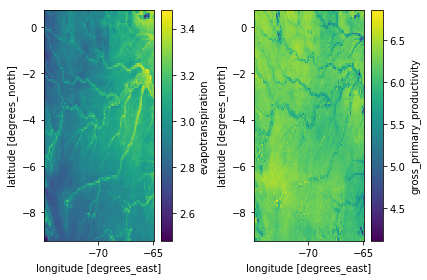

In [129]:
#let's plot the means over time of both variables
plt.subplot(1, 2, 1)
sectionCol.evapotranspiration.reduce(np.mean,dim='time').plot()

plt.subplot(1, 2, 2)
sectionCol.gross_primary_productivity.reduce(np.mean,dim='time').plot()

plt.tight_layout()
plt.show()

In [136]:
#now let's transform it into the frequency domain
freqCube=time2freqDataset(sectionCol,variables=variables)
freqCube

<xarray.Dataset>
Dimensions:                     (frequency: 690, lat: 120, lon: 120)
Coordinates:
  * lon                         (lon) float64 -74.88 -74.79 ... -65.04 -64.96
  * frequency                   (frequency) float64 0.0 0.0001812 ... -0.0001812
  * lat                         (lat) float64 0.7087 0.6254 ... -9.125 -9.208
Data variables:
    evapotranspiration          (frequency, lat, lon) float32 dask.array<shape=(690, 120, 120), chunksize=(184, 60, 60)>
    gross_primary_productivity  (frequency, lat, lon) float32 dask.array<shape=(690, 120, 120), chunksize=(184, 60, 60)>
Attributes:
    CHANGELOG:    \nversion 2.0.1\n---------------\n* Switched to zarr data f...
    cube.config:  {'calendar': 'gregorian', 'chunk_sizes': [184, 60, 60], 'co...

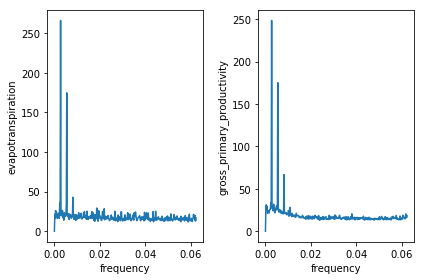

In [169]:
#since the region isn't very large and in the amazon, let's assume that it has similar frequencies to plot
#the seasonality of the region

plt.subplot(1, 2, 1)
freqET=freqCube.evapotranspiration.reduce(np.mean,dim='lon').reduce(np.mean,dim='lat')
freqET.plot()

plt.subplot(1, 2, 2)
freqGPP=freqCube.gross_primary_productivity.reduce(np.mean,dim='lon').reduce(np.mean,dim='lat')
freqGPP.plot()

plt.tight_layout()
plt.show()

In [170]:
#here we can crearly see that there are 2 or 3 main frequencies that dominante the seasonality of this region.
#let's select those 3 frequencies.

#we first find the biggest fourier coefficients
coeffET=Nmax(list(freqET.values),N=3)
coeffGPP=Nmax(list(freqGPP.values),N=3)
print('These are the 3 main Fourier coefficients of each signal',coeffET,coeffGPP)

#then we find the indexes of those coefficients 
indexET=find_Index(freqET.values,coeffET)
indexGPP=find_Index(freqGPP.values,coeffGPP)

#now we select the corresponding frequencies by those indexes
freqET=freqCube['frequency'].values[indexET]
freqGPP=freqCube['frequency'].values[indexGPP]
print('The main frequencies of the signals are:',freqET,freqGPP)

These are the 3 main Fourier coefficients of each signal [266.2138, 174.79411, 42.992805] [248.56425, 175.0904, 66.731186]
The main frequencies of the signals are: [0.00271739 0.00543478 0.00815217] [0.00271739 0.00543478 0.00815217]


In [175]:
#now let's transform those frequencies into periods round them.
#the sampling spacing is of 8 days
periodET=np.reciprocal(freqET)*8
periodGPP=np.reciprocal(freqGPP)*8
monthLen=365/12
print('The main periods in days of the signals are:',np.round(periodET),np.round(periodGPP))
print('The main periods in months of the signals are:',np.round(periodET/monthLen),np.round(periodGPP/30))
print('The main periods in years of the signals are:',np.round(periodET/365),np.round(periodGPP/365))

The main periods in days of the signals are: [2944. 1472.  981.] [2944. 1472.  981.]
The main periods in months of the signals are: [97. 48. 32.] [98. 49. 33.]
The main periods in years of the signals are: [8. 4. 3.] [8. 4. 3.]


## We can clearly see a pattern in these 2 variables, perhaps those periods are asociated with the El Niño and La Niña phenomena!
